#### IMPORT PACKAGES

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

### LOAD DATASET (1 Year)

[Source](https://www.blockchain.com/explorer/charts)

In [50]:
directory = os.path.abspath("") + '/dataset/bitcoin/'
data = pd.read_json(directory + 'data.json')
tps = pd.read_json(directory + 'tps.json')

### CLASSICAL SIGNATURE (ECDSA) EVALUATION

#### RENAME FEATURES

In [51]:
ECDSA = data.copy()

ECDSA_TPS = tps.copy()

ECDSA.rename(columns = {'n-transactions-per-block': 'NoTxPerBlock', 'avg-block-size': 'AvgBlockSize', 'fees-usd-per-transaction': 'FeePerTx'}, inplace = True)

#### FEATURE EXTRACTION

In [52]:
# Extract corresponding values from object
ECDSA['Timestamp'] = ECDSA['NoTxPerBlock'].apply(lambda x: x['x'])

# Convert milliseconds to seconds
ECDSA['Timestamp'] = ECDSA['Timestamp'] / 1000

ECDSA['Date'] = ECDSA['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))

ECDSA['NoTxPerBlock'] = ECDSA['NoTxPerBlock'].apply(lambda x: x['y'])

ECDSA['FeePerTx'] = ECDSA['FeePerTx'].apply(lambda x: x['y'])

# Average block size in bytes - block header size (80 bytes)
ECDSA['AvgBlockSize'] = ECDSA['AvgBlockSize'].apply(lambda x: (x['y'] * 1000000) - 80)

ECDSA['AvgTxSize'] = ECDSA['AvgBlockSize'] / ECDSA['NoTxPerBlock']

# Max No of Transactions possible in a 4 MB
ECDSA['NoMaxTxPossible'] = (4 * 1000000) / ECDSA['AvgTxSize']

ECDSA_TPS['Timestamp'] = ECDSA_TPS['transactions-per-second'].apply(lambda x: x['x'])

# Convert milliseconds to seconds
ECDSA_TPS['Timestamp'] = ECDSA_TPS['Timestamp'] / 1000

ECDSA_TPS['TPS'] = ECDSA_TPS['transactions-per-second'].apply(lambda x: x['y'])

# Perform an asof merge
ECDSA = pd.merge_asof(ECDSA, ECDSA_TPS[['Timestamp', 'TPS']], on='Timestamp', direction='nearest')

# seconds
ECDSA['BlockTime'] = (ECDSA['AvgBlockSize'] / ECDSA['AvgTxSize']) / ECDSA['TPS']

ECDSA.describe()

,AvgBlockSize,FeePerTx,NoTxPerBlock,Timestamp,Date,AvgTxSize,NoMaxTxPossible,TPS,BlockTime
count,3.640000e+02,364.000000,364.000000,3.640000e+02,364,364.000000,364.000000,364.000000,364.000000
mean,1.733976e+06,4.943903,2933.657283,1.690027e+09,2023-07-22 12:00:00,643.584608,6893.740692,4.625237,643.612220
min,9.600754e+05,0.631596,1430.216374,1.674346e+09,2023-01-22 00:00:00,362.455387,2555.043850,2.597396,393.333328
25%,1.646336e+06,1.576201,2263.857447,1.682186e+09,2023-04-22 18:00:00,475.005217,5224.386066,3.617187,564.952766
50%,1.696551e+06,2.330580,2998.069718,1.690027e+09,2023-07-22 12:00:00,556.289221,7190.504841,4.331163,633.635239
75%,1.789406e+06,5.284453,3547.784657,1.697868e+09,2023-10-21 06:00:00,765.640612,8420.962998,5.412500,711.936310
max,2.524705e+06,37.384599,4688.147436,1.705709e+09,2024-01-20 00:00:00,1565.530862,11035.840932,10.788715,1390.893031
std,2.021616e+05,6.242922,756.139153,9.091180e+06,NaN,235.668498,1967.489029,1.291138,115.164013


#### CORRELATION MATRIX

Text(0.5, 1.0, 'Correlation between features')

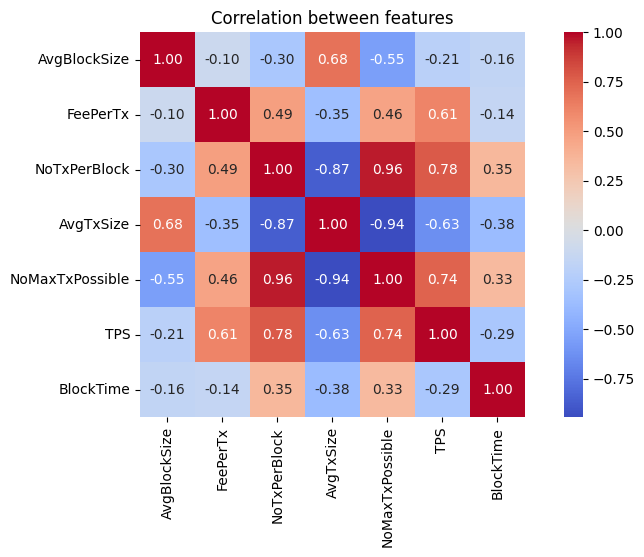

In [53]:
ECDSA_CORR = ECDSA.copy().drop(labels=['Timestamp', 'Date'], axis=1).corr()
plt.figure(figsize=(10,5))
sns.heatmap(ECDSA_CORR, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.title('Correlation between features')

### COMPARISON OF POST-QUANTUM SIGNATURES

[Speed Comparison](https://openquantumsafe.org/benchmarking/visualization/speed_sig.html)

1. Level 1: Algorithm is at least as hard to break as AES128.
2. Level 2: Algorithm is at least as hard to break as SHA256.
3. Level 3: Algorithm is at least as hard to break as AES192.
4. Level 4: Algorithm is at least as hard to break as SHA384.
5. Level 5: Algorithm is at least as hard to break as AES256.

Since ECDSA 256-bit is equivalent to AES128, we will focus on Level 1 only.

#### PQ TRANSACTION SIZE FUNCTION

> Calculates the average transaction size considering the replacement of ECDSA signatures and public keys with post-quantum (PQ) signatures and public keys.

    Parameters:
    - ECDSATxSize (float): Original transaction size with ECDSA signatures and public keys.
    - PQ_SIG_SIZE (int): Size of the post-quantum signature.
    - PQ_PUB_SIZE (int): Size of the post-quantum public key.

    Returns:
    - float: Average transaction size with PQ signatures and public keys.

In [54]:
def getPQAvgTransactionSize(ECDSATxSize, PQ_SIG_SIZE: int):
    
    # ECDSA (bytes)
    ECDSA_SIG_SIZE = 71.33 # over the last year around 67% used 71 bytes and 33% used 72 bytes so weighted average is 71.33

    PQ_TxSize = ECDSATxSize - ECDSA_SIG_SIZE  + PQ_SIG_SIZE

    return PQ_TxSize

#### [FALCON-512](https://falcon-sign.info/)

* NIST LEVEL 1 Security

In [55]:
FALCON_512_SIG_SIZE = 666 # (bytes)

FALCON = pd.DataFrame()

FALCON['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], FALCON_512_SIG_SIZE)

# Max No of Transactions possible in a 4 MB
FALCON['NoMaxTxPossible'] = (4 * 1000000) / FALCON['AvgTxSize']

FALCON.describe()

,AvgTxSize,NoMaxTxPossible
count,364.000000,364.000000
mean,1238.254608,3329.048513
std,235.668498,529.788802
min,957.125387,1851.679661
25%,1069.675217,2940.505385
50%,1150.959221,3475.362121
75%,1360.310612,3739.453064
max,2160.200862,4179.180756


#### [DILITHIUM-2](https://pq-crystals.org/dilithium/)

* NIST LEVEL 1 Security

In [56]:
DILITHIUM_SIG_SIZE = 2420 # (bytes)

DILITHIUM = pd.DataFrame()

DILITHIUM['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], DILITHIUM_SIG_SIZE)

# Max No of Transactions possible in a 4 MB
DILITHIUM['NoMaxTxPossible'] = (4 * 1000000) / DILITHIUM['AvgTxSize']

DILITHIUM.describe()

,AvgTxSize,NoMaxTxPossible
count,364.000000,364.000000
mean,2992.254608,1344.340824
std,235.668498,96.589579
min,2711.125387,1021.919963
25%,2823.675217,1284.393443
50%,2904.959221,1376.955650
75%,3114.310612,1416.593528
max,3914.200862,1475.402067


#### [SPHINCS+128f](https://openquantumsafe.org/liboqs/algorithms/sig/sphincs.html)

* NIST LEVEL 1 Security

In [57]:
SPHINCS_SIG_SIZE = 17088 # (bytes)

SPHINCS = pd.DataFrame()

SPHINCS['AvgTxSize'] = getPQAvgTransactionSize(ECDSA['AvgTxSize'], SPHINCS_SIG_SIZE)

# Max No of Transactions possible in a 4 MB
SPHINCS['NoMaxTxPossible'] = (4 * 1000000) / SPHINCS['AvgTxSize']

SPHINCS.describe()

,AvgTxSize,NoMaxTxPossible
count,364.000000,364.000000
mean,17660.254608,226.536809
std,235.668498,2.969194
min,17379.125387,215.259755
25%,17491.675217,224.942646
50%,17572.959221,227.622448
75%,17782.310612,228.680212
max,18582.200862,230.161180


#### GRAPH COMPARISONS

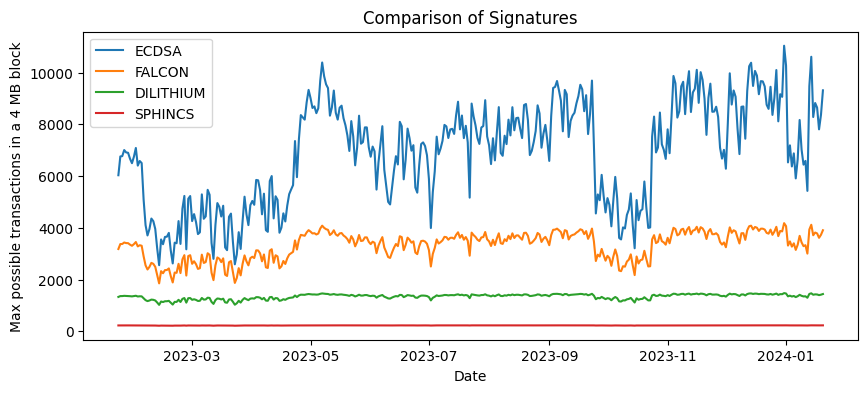

In [58]:
plt.figure(figsize=(10, 4))

plt.plot(ECDSA['Date'], ECDSA['NoMaxTxPossible'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['NoMaxTxPossible'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['NoMaxTxPossible'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['NoMaxTxPossible'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Max possible transactions in a 4 MB block')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

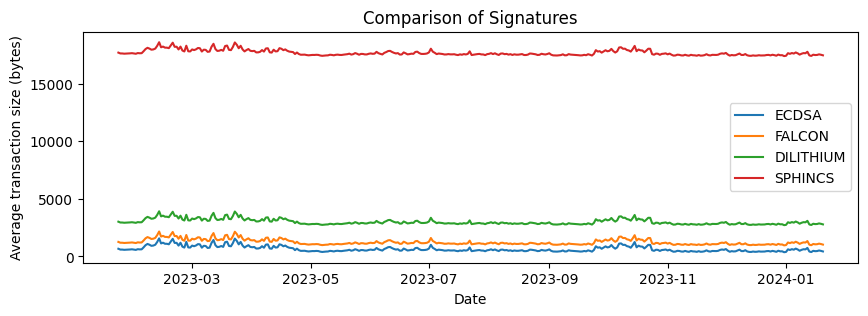

In [59]:
plt.figure(figsize=(10, 3))

plt.plot(ECDSA['Date'],ECDSA['AvgTxSize'], label='ECDSA')
plt.plot(ECDSA['Date'],FALCON['AvgTxSize'], label='FALCON')
plt.plot(ECDSA['Date'],DILITHIUM['AvgTxSize'], label='DILITHIUM')
plt.plot(ECDSA['Date'],SPHINCS['AvgTxSize'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transaction size (bytes)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

"Our results show that the PQ algorithms with the best performance for
time‐sensitive applications are Dilithium and Falcon." [Sikeridis et al., 2020](https://doi.org/10.14722/ndss.2020.24203)



### PROJECTIONS

#### TRANSACTION FEE FUNCTION (BITCOIN)

> Transaction fees = Transaction size (in bytes) * Fee rate (in satoshis per byte)

where Fee rate depends on the market conditions and the network congestion.

In [60]:
ECDSA['AvgFeeRate'] = ECDSA['FeePerTx'] / ECDSA['AvgTxSize']
FALCON['FeePerTx'] = FALCON['AvgTxSize'] * ECDSA['AvgFeeRate']
DILITHIUM['FeePerTx'] = DILITHIUM['AvgTxSize'] * ECDSA['AvgFeeRate']
SPHINCS['FeePerTx'] = SPHINCS['AvgTxSize'] * ECDSA['AvgFeeRate']

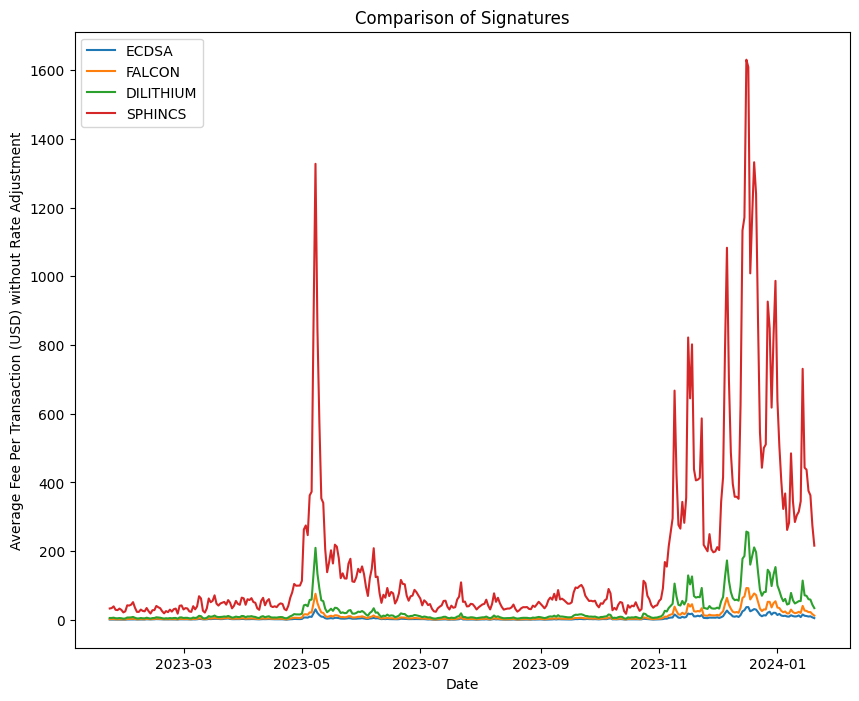

In [61]:
# Plot data from all three DataFrames
plt.figure(figsize=(10, 8))

plt.plot(ECDSA['Date'], ECDSA['FeePerTx'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['FeePerTx'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['FeePerTx'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['FeePerTx'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average Fee Per Transaction (USD) without Rate Adjustment')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

### FEE RATE ADJUSTMENT

In order to maintain the same fee per transaction, the fee rate must be adjusted.

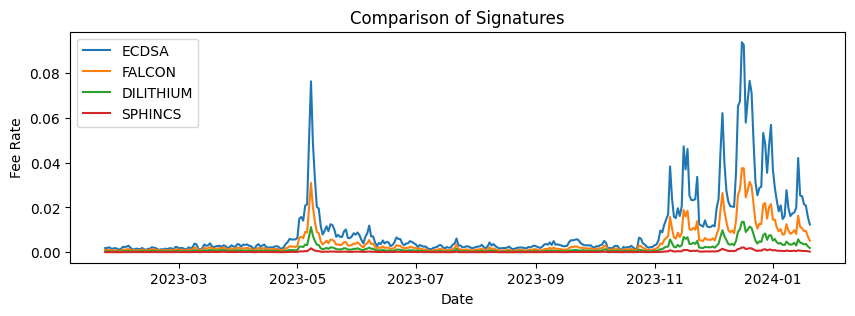

In [62]:
# Calculate the FeeRate for PQ algorithms using the same FeePerTx as ECDSA
FALCON['AvgFeeRate'] = ECDSA['FeePerTx'] / FALCON['AvgTxSize']
DILITHIUM['AvgFeeRate'] = ECDSA['FeePerTx'] / DILITHIUM['AvgTxSize']
SPHINCS['AvgFeeRate'] = ECDSA['FeePerTx'] / SPHINCS['AvgTxSize']

# Plot data from all three DataFrames
plt.figure(figsize=(10, 3))

plt.plot(ECDSA['Date'], ECDSA['AvgFeeRate'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['AvgFeeRate'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['AvgFeeRate'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['AvgFeeRate'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Fee Rate')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()

#### TRANSACTION THROUGHPUT

> Transactions per second = (block size/transaction size) / block time

#### AVERAGE TRANSACTIONS PER SECOND

> Average TPS = (Average Block Size / Average Transaction Size) / Average Block Time

In [63]:
ECDSA['AverageTPS'] = (ECDSA['AvgBlockSize'] / ECDSA['AvgTxSize']) / ECDSA['BlockTime']
FALCON['AverageTPS'] = (ECDSA['AvgBlockSize'] / FALCON['AvgTxSize']) / ECDSA['BlockTime']
DILITHIUM['AverageTPS'] = (ECDSA['AvgBlockSize'] / DILITHIUM['AvgTxSize']) / ECDSA['BlockTime']
SPHINCS['AverageTPS'] = (ECDSA['AvgBlockSize'] / SPHINCS['AvgTxSize']) / ECDSA['BlockTime']

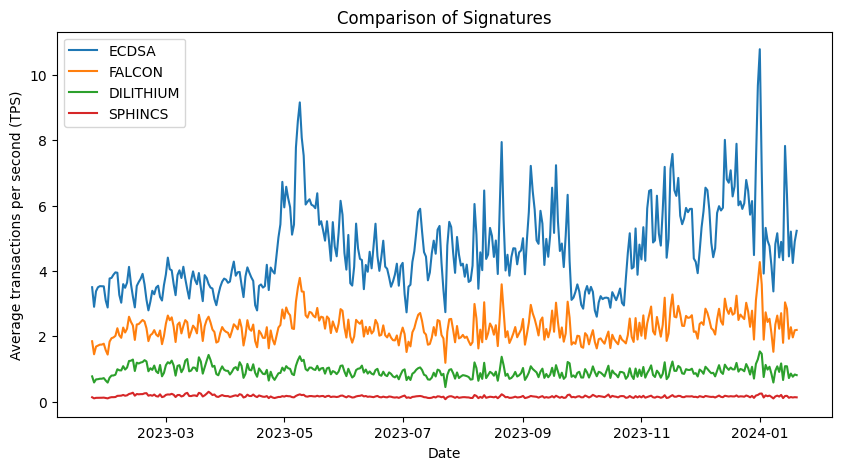

In [64]:
plt.figure(figsize=(10, 5))

plt.plot(ECDSA['Date'], ECDSA['AverageTPS'], label='ECDSA')
plt.plot(ECDSA['Date'], FALCON['AverageTPS'], label='FALCON')
plt.plot(ECDSA['Date'], DILITHIUM['AverageTPS'], label='DILITHIUM')
plt.plot(ECDSA['Date'], SPHINCS['AverageTPS'], label='SPHINCS')

plt.xlabel('Date')
plt.ylabel('Average transactions per second (TPS)')
plt.title('Comparison of Signatures')
plt.legend()
plt.show()